# Computer vision and deep learning - Laboratory 6

In this last laboratory, we will switch our focus from implementing and training neural networks to developing a machine learning application.
More specifically you will learn how you can convert your saved torch model into a more portable format using torch script and how you can create a simple demo application for your model.



## Converting your model into portable TorchScript binaries


``TorchScript`` allows you to create serializable and optimizable models from PyTorch code and then use them in a process where there is no Python dependency.


When deploying our module in production systems, we might need to run the model using another programming language (not Python) and even on mobile or embedded devices. In addition, we need a more lightweight environment than the development one.


Until now, when training a model we've saved checkpoints and reloaded the weights when needed into the development environment. As the name suggests, the checkpoints contain additional information (such as optimizer states) which allows you to resume the training process. However, all this information is not required during inference.




``Torchscript`` allows you to create a lightweight and independent model artifact suitable for runtime via two different techniques: scripting and tracing. They are both used to convert a PyTorch model into a more optimized or deployable form.




Tracing involves capturing a model's execution trace by passing example inputs through the model and recording the operations executed. This creates a TorchScript representation of the model based on the traced operations. However, tracing might not capture all dynamic aspects of the model, especially if the model's behavior changes dynamically based on input data or control flow operations. Tracing is more focused on capturing the specific operations executed with example inputs, which might be more efficient but might not cover all dynamic behaviors of complex models.




Scripting, on the other hand, refers to converting a PyTorch model (built using PyTorch's dynamic computation graph with Python control flow, such as loops and if statements) into a TorchScript. This involves representing the model as a static computation graph that can be executed independently of Python. Scripting allows the model to be saved and run in environments where a Python interpreter might not be available. Scripting captures the entire model logic and can handle more complex models with Pythonic control flow, making it more flexible but potentially more complex.


Both techniques aim to transform PyTorch models into TorchScript representations, making them efficient for deployment in various environments or for optimized execution, albeit with different approaches. The choice between scripting and tracing depends on the specific use case, model complexity, and deployment requirements.

You can check out the [documentation](https://pytorch.org/docs/stable/jit.html) for further details on ``TorchScript``.



Below you have an example that demonstrates the conversion of a pre-trained ResNet-18 model from torchvision into a TorchScript and then loading and using the saved TorchScript model for inference:

In [22]:
import os
import sys
import cv2
import wget
import glob
import wandb
import shutil
import numpy as np
import numpy.testing as npt
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import v2
from torchvision.datasets import VisionDataset
from torch.utils.data import Subset, DataLoader
from torchvision.datasets.utils import check_integrity, download_and_extract_archive, download_url, verify_str_arg
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
import shutil
from PIL import Image,ImageFile
import glob
import os
import sys
import torch
from torch import Tensor
import torch.testing as torch_testing
from torch.utils.data import Subset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision
import numpy as np
import numpy.testing as npt
from functools import reduce
import matplotlib.pyplot as plt
import os
import pickle
import cv2
from dataclasses import dataclass
import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data.dataloader import default_collate
import pprofile
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import torchmetrics
import wandb
import dataclasses
import torchvision.models as models
import gradio as gr

In [23]:
model = models.resnet18(pretrained=True)
model.eval()

# Create a sample input tensor (change according to your model's input requirements)
example_input = torch.randn(1, 3, 224, 224)

# Script the model
scripted_model = torch.jit.script(model)

# Save the scripted model to a file
scripted_model.save("scripted_resnet18.pt")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
class DoubleConvolution(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(DoubleConvolution, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x: Tensor) -> Tensor:
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64,128,256,512]):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConvolution(in_channels, feature))
            in_channels = feature
        
        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConvolution(feature*2, feature))
        
        self.bottleneck = DoubleConvolution(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
    
    def forward(self, x: Tensor) -> Tensor:
        skip_connections = []
        
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        for idx,up in enumerate(self.ups):
            if (idx%2 == 0):
                x=up(x)
                if x.shape != skip_connections[idx//2].shape:
                    x = TF.resize(x, size=skip_connections[idx//2].shape[2:])
                x=torch.cat((skip_connections[idx//2],x),dim=1)
            else:
                x = up(x)
        
        return self.final_conv(x)


@dataclasses.dataclass
class InputParameters:
    model: nn.Module
    optimizer: torch.optim.Optimizer
    scheduler: torch.optim.lr_scheduler._LRScheduler

In [25]:
def load_model(filename):
    print("=> Loading checkpoint")
    input_parameters = torch.load(filename)
    return input_parameters.model

# https://github.com/pytorch/pytorch/issues/47496
segmentation_model = load_model("model.pth")
segmentation_model = torch.jit.script(segmentation_model)
segmentation_model.save("segmentation_model.pt")

=> Loading checkpoint


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Text(0.5, 1.0, 'Segmentation')

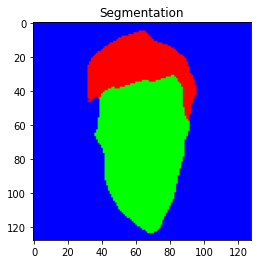

In [26]:
# Example usage:
transforms = v2.Compose([v2.Resize(128), v2.ToTensor()])
with Image.open("example_1.jpg") as image:
    image.convert("RGB")

transformed_image = transforms(image).to("cuda")
transformed_image = transformed_image.unsqueeze(0)

preds = segmentation_model(transformed_image).argmax(dim=1)
computed_segmentation = F.one_hot(preds[0]).float().cpu().numpy()
plt.imshow(computed_segmentation)
plt.title(f"Segmentation")

The main steps of the process are:
- load the pre-trained model and set it to evaluation mode with model.eval().
- create a sample input tensor (example_input) that matches the expected input shape of the model.
- use ```torch.jit.script()``` to convert the model into a TorchScript representation.
- save the scripted model to a file using ```scripted_model.save()``` for later use or deployment.

Now, let's see how you can use the scripted model:

In [27]:
from io import BytesIO
import requests
from torchvision.models import  ResNet18_Weights

# Load the saved TorchScript model
model = torch.jit.load("scripted_resnet18.pt")


preprocess = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


image_url = 'https://images.unsplash.com/photo-1611267254323-4db7b39c732c?q=80&w=1000&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8M3x8Y3V0ZSUyMGNhdHxlbnwwfHwwfHx8MA%3D%3D'
response = requests.get(image_url)
image = Image.open(BytesIO(response.content)).convert('RGB')
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension
with torch.no_grad():
    # run the scripted model
    output_image = model(input_batch)
weights = ResNet18_Weights.DEFAULT
class_names = weights.meta["categories"]
# Get the top 5 predictions
probabilities = torch.nn.functional.softmax(output_image[0], dim=0)
top5_prob, top5_catid = torch.topk(probabilities, 5)

# Display top 5 predicted classes and their probabilities
for i in range(top5_prob.size(0)):
    class_idx = top5_catid[i].item()
    print(f"Prediction: {class_names[class_idx]}, Probability: {top5_prob[i].item():.4f}")

Prediction: tabby, Probability: 0.7649
Prediction: tiger cat, Probability: 0.1408
Prediction: Egyptian cat, Probability: 0.0876
Prediction: Persian cat, Probability: 0.0024
Prediction: lynx, Probability: 0.0013


Optionally, you can also save the torchscript binary into ```wandb```. In this way, you will have a connection link between the model that is running in production and the training runs that you logged during training.

# Creating a simple UI with gradio


[Gradio](https://www.gradio.app/docs/interface) is an open-source Python library used for creating customizable UI components for machine learning models with just a few lines of code. It greatly simplifies the process of building web-based interfaces to interact with ML models without requiring extensive knowledge of web development and allows you to quickly build an MVP and get feedback from the users.


To get an application running, you just need to specify three parameters:
1. the function to wrap the interface around.
2. what are the desired input components?
3. what are the desired output components?


This is achieved through the ``gradio.Interface`` class, the central component in gradio, responsible for creating the user interface for your machine learning model.


```
import gradio as gr
demo = gr.Interface(fn=image_classifier,
                    inputs="image",
                    outputs="label")


```


Once you've defined the gr.Interface, the launch() method is used to start the interface, making it accessible through a web browser.


```
demo.launch()
```


When the launch method is called, ```gradio``` launches a simple web server that serves the demo. If you specify ```share=True``` when calling the launch function, ```gradio``` will create a public link Can also be used to create a public link used by anyone to access the demo from their browser.


## Simple UI for image classification in gradio

Below you have an example of how you could use ```gradio``` to create a simple UI for an image classification problem.

In [29]:
CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

preprocess = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_img(img):
    img = Image.fromarray(img.astype('uint8'), 'RGB')
    img = preprocess(img)
    return img

def classify_image(img):
    img = preprocess_img(img)
    input_batch = img.unsqueeze(0)
    with torch.no_grad():
        output = model(input_batch)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    confidences = {class_names[i]: float(probabilities[i]) for i in range(len(class_names))}
    return confidences

ui = gr.Interface(fn=classify_image,
             inputs=gr.Image(),
             outputs=gr.Label(num_top_classes=3),
             examples=['Abyssinian.jpg', 'Bengal.jpg'],
          )
ui.launch()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


## Accessing the webcam with gradio

In the example below, you have an example in which you take the input images from your webcam.
The function wrapped by gradio uses a mask to blur the input image outside that mask. If you plan to do background blurring, the mask could be the segmentation mask predicted by your model.



In [38]:
import gradio as gr
transforms = v2.Compose([v2.Resize(128), v2.ToTensor()])

def get_segmentation(input_image):
    if isinstance(input_image, str):
        input_image = np.array(Image.open(input_image).convert("RGB"))
    else:
        input_image = Image.fromarray(input_image.astype('uint8'), 'RGB').convert("RGB")

    transformed_image = transforms(input_image).to("cuda")
    transformed_image = transformed_image.unsqueeze(0)

    preds = segmentation_model(transformed_image).argmax(dim=1)
    computed_segmentation = F.one_hot(preds[0]).float().cpu().numpy()
    # Convert to gradio:
    return computed_segmentation


ui = gr.Interface(
    fn=get_segmentation,
    live=True,
    inputs=[gr.Image(sources=["webcam"], streaming=True)],
    outputs=[gr.Image()],
    title="Image segmentation demo!",
)
ui.launch()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Running on local URL:  http://127.0.0.1:7868

To create a public link, set `share=True` in `launch()`.


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

## Laboratory assignment


Now you have all the knowledge required to build your own ML semantic segmentation application.


1. First use ```torchscript``` to obtain a model binary.
2. Using gradio, create a simple application that uses the semantic segmentation that you developed. Feel free to define the scope and the functional requirements of your app.
3. __[Optional, independent work]__ Use a serverless cloud function on [AWS Lambda](https://aws.amazon.com/lambda/) (this requires an account on Amazon AWS and you need to provide the details of a credit card) to run the prediction and get the results.


Congratulations, you've just completed all the practical work for Computer Vision and Deep Learning!
May your data always be clean, your models accurate, and your code bug-free!



